# <center> XOKind - Machine Learning/Data Science Intern Interview <center>
## <center> Yelp rating predictions <center>
### <center> Traditional Machine learning Vs Graph Machine Learning <center>

#### Traditional Machine Learning - Multilayer Perceptron Neural Networks

In [1]:
#Importing necessary libraries

import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras.utils import np_utils

Using TensorFlow backend.


In [9]:
#Function to generate confusion matrix images from confusion matrix array

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    title_for_figure = "results/" + title+".png"
    plt.savefig(title_for_figure)

In [3]:
# path to data files

business_json_path = 'dataset/business.json'
review_json_path = 'dataset/review.json'
user_json_path = 'dataset/user.json'


In [4]:
#read business file and extract restaurant data

size = 500000

business = pd.read_json(business_json_path, lines=True,
                    dtype={'business_id':str,'name':str,
                             'address':str,'city':str,
                             'latitude':float,'longitude':float,
                             'state':str,'postal_code':str,
                             'stars':float,'review_count':int,
                             'is_open':int,
                             'attributes':object,'categories':object,
                             'hours':object},
                    chunksize=size)


business_drop_columns = ['name', 'address', 'city', 'state', 'postal_code',
                         'latitude', 'longitude', 'attributes', 'hours']
chunk_list_business = []

for chunk_business in business:
    # Drop columns that aren't needed
    chunk_business = chunk_business.drop(business_drop_columns, axis=1)
    
    # Renaming column name to avoid conflicts
    chunk_business.rename(columns={'stars': 'business_stars', 'review_count': 'business_review_count',
                                      'review_stars': 'business_review_stars'}, inplace=True)
    
    chunk_business = chunk_business[chunk_business['categories'].str.contains('Restaurants', case=True,na=False)]
    
    chunk_list_business.append(chunk_business)

    
df_restaurants = pd.concat(chunk_list_business, ignore_index=True, join='outer', axis=0)

In [6]:
df_restaurants.head()

,business_id,business_stars,business_review_count,is_open,categories
0,pQeaRpvuhoEqudo3uymHIQ,4.5,5,1,"Ethnic Food, Food Trucks, Specialty Food, Impo..."
1,CsLQLiRoafpJPJSkNX2h5Q,3.0,5,0,"Food, Restaurants, Grocery, Middle Eastern"
2,eBEfgOPG7pvFhb2wcG9I7w,4.5,4,1,"Restaurants, Cheesesteaks, Poutineries"
3,lu7vtrp_bE9PnxWfA8g4Pg,4.5,7,1,"Japanese, Fast Food, Food Court, Restaurants"
4,9sRGfSVEfLhN_km60YruTA,3.0,3,1,"Persian/Iranian, Turkish, Middle Eastern, Rest..."


In [5]:
#Delete non-essential data to save memory

del chunk_business
del chunk_list_business

In [7]:
# =============================================================================
# Reviews data
# =============================================================================
size = 500000

review = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)

chunk_list = []
for chunk_review in review:
    
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['text', 'date', 'review_id','useful','funny','cool'], axis=1)
    
    # Renaming column name to avoid conflicts
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    
    # Inner merge with edited business file so only reviews related to the restaurants remain
    chunk_merged = pd.merge(df_restaurants, chunk_review, on='business_id', how='inner')
    
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    
    chunk_list.append(chunk_merged)

    
# After trimming down the review file, concatenate all relevant data back to one dataframe
df_restaurant_reviews = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

df_restaurant_reviews.head()

330699 out of 500,000 related reviews
303722 out of 500,000 related reviews
311627 out of 500,000 related reviews
319846 out of 500,000 related reviews
296928 out of 500,000 related reviews
331148 out of 500,000 related reviews
312615 out of 500,000 related reviews
312472 out of 500,000 related reviews
323678 out of 500,000 related reviews
299857 out of 500,000 related reviews
315579 out of 500,000 related reviews
325414 out of 500,000 related reviews
307972 out of 500,000 related reviews
330227 out of 500,000 related reviews
311351 out of 500,000 related reviews
311776 out of 500,000 related reviews
11081 out of 500,000 related reviews


,business_id,business_stars,business_review_count,is_open,categories,user_id,review_stars
0,pQeaRpvuhoEqudo3uymHIQ,4.5,5,1,"Ethnic Food, Food Trucks, Specialty Food, Impo...",eSQ3z93DlzkpXK_H6MFEMw,5
1,pQeaRpvuhoEqudo3uymHIQ,4.5,5,1,"Ethnic Food, Food Trucks, Specialty Food, Impo...",5So3uZiWDmow4eG8Va0WhQ,5
2,pQeaRpvuhoEqudo3uymHIQ,4.5,5,1,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Oh1CPqH5zBZfDEC_2ueTow,2
3,CsLQLiRoafpJPJSkNX2h5Q,3.0,5,0,"Food, Restaurants, Grocery, Middle Eastern",whqfWVBj4x5EDboIVDOymQ,3
4,CsLQLiRoafpJPJSkNX2h5Q,3.0,5,0,"Food, Restaurants, Grocery, Middle Eastern",TQXtrSpsUyvHMriX8hvNWQ,3


In [8]:
#Delete non-essential data to save memory

del chunk_review
del chunk_merged
del chunk_list

In [10]:
# =============================================================================
# User data
# =============================================================================

size = 500000

user = pd.read_json(user_json_path, lines=True,
                      dtype={'user_id':str,'name':str,
                             'yelping_since':str,'review_count':int,
                             'friends':object,'useful':int,
                             'funny':int,'cool':int,'fans':int,
                             'elite':list, 'average_stars':float,'compliment_hot':int,
                             'compliment_more':int,'compliment_more':int,'compliment_profile':int,
                             'compliment_cute':int,'compliment_list':int,'compliment_note':int,
                             'compliment_plain':int,'compliment_cool':int,'compliment_funny':int,
                             'compliment_writer':int,'compliment_photos':int},
                      chunksize=size)

user_drop_columns = ['name', 'yelping_since', 'friends']

chunk_list_user = []

for chunk_user in user:
    # Drop columns that aren't needed
    chunk_user = chunk_user.drop(user_drop_columns, axis=1)
    
    # Renaming column name to avoid conflicts
    chunk_user.rename(columns={'review_count': 'user_review_count', 'average_stars': 'user_average_stars'})
    
    chunk_list_user.append(chunk_user)

    
# concatenate to one dataframe
df_user = pd.concat(chunk_list_user, ignore_index=True, join='outer', axis=0)

df_user.head()

,user_id,review_count,useful,funny,cool,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,553,628,225,227,,14,3.57,3,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,564,790,316,400,"2008,2009,2010,2011,2012,2013",27,3.84,36,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,60,151,125,103,2010,5,3.44,9,6,0,1,0,3,7,17,17,4,1
3,QaELAmRcDc5TfJEylaaP8g,206,233,160,84,2009,6,3.08,2,1,0,0,0,7,14,7,7,2,0
4,xvu8G900tezTzbbfqmTKvA,485,1265,400,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018",78,4.37,8,9,2,1,1,22,28,31,31,19,31


In [11]:
#Delete non-essential data to save memory

del chunk_user
del chunk_list_user

In [12]:
# Merge users and restaurant reviews data --> this dataframe will contain information about user, restaurant and review

merged_df = df_user.merge(df_restaurant_reviews, how='inner', left_on=["user_id"], right_on=["user_id"])

merged_df.head()

,user_id,review_count,useful,funny,cool,elite,fans,average_stars,compliment_hot,compliment_more,...,compliment_cool,compliment_funny,compliment_writer,compliment_photos,business_id,business_stars,business_review_count,is_open,categories,review_stars
0,ntlvfPzc8eglqvk92iDIAw,553,628,225,227,,14,3.57,3,2,...,22,22,10,0,8nP8ghEpT6WFcM6tfqAaGA,3.5,720,1,"Ice Cream & Frozen Yogurt, Sandwiches, Food, A...",2
1,ntlvfPzc8eglqvk92iDIAw,553,628,225,227,,14,3.57,3,2,...,22,22,10,0,oaqbLDW3wNqkynlnp4mvlw,3.5,653,1,"Italian, Restaurants",2
2,ntlvfPzc8eglqvk92iDIAw,553,628,225,227,,14,3.57,3,2,...,22,22,10,0,rcaPajgKOJC2vo_l3xa42A,4.0,4138,1,"French, Cafes, Restaurants, Cocktail Bars, Nig...",4
3,ntlvfPzc8eglqvk92iDIAw,553,628,225,227,,14,3.57,3,2,...,22,22,10,0,ID5wWJ9C7G0hfbQilvlfxA,3.5,729,1,"Bars, Restaurants, Cocktail Bars, Tacos, Mexic...",4
4,ntlvfPzc8eglqvk92iDIAw,553,628,225,227,,14,3.57,3,2,...,22,22,10,0,3JekfARgFuMeLTMcOpgqyQ,4.5,191,1,"Restaurants, Sandwiches, Desserts, Food, Ice C...",3


In [13]:
#Delete non-essential data to save memory

del df_user
del df_restaurant_reviews

In [14]:
# Create a new feature mean compliment score for each users

merged_drop_columns = ['business_id', 'user_id', 'elite']

merged_df.drop(merged_drop_columns, axis = 1, inplace = True)

compliment_columns = ['compliment_cool', 'compliment_cute', 'compliment_funny', 
                               'compliment_hot', 'compliment_list', 'compliment_more',
                               'compliment_note', 'compliment_photos', 'compliment_plain', 
                               'compliment_profile', 'compliment_writer']


merged_df['mean_compliment_score'] = merged_df.loc[: , compliment_columns].mean(axis=1)


merged_df.drop(compliment_columns, axis = 1, inplace = True)

merged_df.head()

,review_count,useful,funny,cool,fans,average_stars,business_stars,business_review_count,is_open,categories,review_stars,mean_compliment_score
0,553,628,225,227,14,3.57,3.5,720,1,"Ice Cream & Frozen Yogurt, Sandwiches, Food, A...",2,7.909091
1,553,628,225,227,14,3.57,3.5,653,1,"Italian, Restaurants",2,7.909091
2,553,628,225,227,14,3.57,4.0,4138,1,"French, Cafes, Restaurants, Cocktail Bars, Nig...",4,7.909091
3,553,628,225,227,14,3.57,3.5,729,1,"Bars, Restaurants, Cocktail Bars, Tacos, Mexic...",4,7.909091
4,553,628,225,227,14,3.57,4.5,191,1,"Restaurants, Sandwiches, Desserts, Food, Ice C...",3,7.909091


In [16]:
# Expand by restaurant category to investigate restaurent categories and their overall count in data

df_yelp_expand_by_category = merged_df.assign(categories = merged_df.categories
                         .str.split(', ')).explode('categories')
df_yelp_category_count = df_yelp_expand_by_category.categories.value_counts()

df_yelp_expand_by_category.head()

,review_count,useful,funny,cool,fans,average_stars,business_stars,business_review_count,is_open,categories,review_stars,mean_compliment_score
0,553,628,225,227,14,3.57,3.5,720,1,Ice Cream & Frozen Yogurt,2,7.909091
0,553,628,225,227,14,3.57,3.5,720,1,Sandwiches,2,7.909091
0,553,628,225,227,14,3.57,3.5,720,1,Food,2,7.909091
0,553,628,225,227,14,3.57,3.5,720,1,American (Traditional),2,7.909091
0,553,628,225,227,14,3.57,3.5,720,1,Restaurants,2,7.909091


In [18]:
df_yelp_category_count.head(11)

Restaurants               5055992
Food                      1394078
Nightlife                 1267512
Bars                      1227097
American (Traditional)     902047
American (New)             881417
Breakfast & Brunch         838307
Sandwiches                 586848
Mexican                    499055
Burgers                    494426
Pizza                      479792
Name: categories, dtype: int64

In [19]:
# Selecting top 10 restaurants based on count
top_10_restaurants = list(df_yelp_category_count.index.values)[1:11] #first element is Resturant, so index 1 to 11


df_yelp_top10 = df_yelp_expand_by_category.loc[df_yelp_expand_by_category['categories'].isin(top_10_restaurants)]

df_yelp_top10.head()

,review_count,useful,funny,cool,fans,average_stars,business_stars,business_review_count,is_open,categories,review_stars,mean_compliment_score
0,553,628,225,227,14,3.57,3.5,720,1,Sandwiches,2,7.909091
0,553,628,225,227,14,3.57,3.5,720,1,Food,2,7.909091
0,553,628,225,227,14,3.57,3.5,720,1,American (Traditional),2,7.909091
2,553,628,225,227,14,3.57,4.0,4138,1,Nightlife,4,7.909091
2,553,628,225,227,14,3.57,4.0,4138,1,Bars,4,7.909091


In [25]:
# Create One Hot Encoding for categories column

df_yelp_top10_ohe = pd.get_dummies(data = df_yelp_top10, prefix = 'is', 
                                                     columns = ['categories'], drop_first= True, sparse = True)
df_yelp_top10_ohe.head()

,review_count,useful,funny,cool,fans,average_stars,business_stars,business_review_count,is_open,review_stars,mean_compliment_score,is_American (Traditional),is_Bars,is_Breakfast & Brunch,is_Burgers,is_Food,is_Mexican,is_Nightlife,is_Pizza,is_Sandwiches
0,553,628,225,227,14,3.57,3.5,720,1,2,7.909091,0,0,0,0,0,0,0,0,1
0,553,628,225,227,14,3.57,3.5,720,1,2,7.909091,0,0,0,0,1,0,0,0,0
0,553,628,225,227,14,3.57,3.5,720,1,2,7.909091,1,0,0,0,0,0,0,0,0
2,553,628,225,227,14,3.57,4.0,4138,1,4,7.909091,0,0,0,0,0,0,1,0,0
2,553,628,225,227,14,3.57,4.0,4138,1,4,7.909091,0,1,0,0,0,0,0,0,0


In [21]:
#Delete non-essential data to save memory

del df_yelp_expand_by_category
del merged_df

In [27]:
#Standardize columns - (x- mean(x))/std(x) --> important for Gradient Descent based algorithms such as MLPNN

cols_to_norm = ['review_count','useful', 'funny', 'cool', 'fans', 'average_stars', 'business_stars', 
                'business_review_count', 'mean_compliment_score']

df_yelp_top10_ohe[cols_to_norm] = df_yelp_top10_ohe[cols_to_norm].apply(lambda x: (x - np.mean(x)) / (np.std(x)))

df_yelp_top10_ohe.head()

,review_count,useful,funny,cool,fans,average_stars,business_stars,business_review_count,is_open,review_stars,mean_compliment_score,is_American (Traditional),is_Bars,is_Breakfast & Brunch,is_Burgers,is_Food,is_Mexican,is_Nightlife,is_Pizza,is_Sandwiches
0,1.236976,0.074949,0.010345,-0.028027,0.021685,-0.258375,-0.409617,0.001942,1,2,-0.053235,0,0,0,0,0,0,0,0,1
0,1.236976,0.074949,0.010345,-0.028027,0.021685,-0.258375,-0.409617,0.001942,1,2,-0.053235,0,0,0,0,1,0,0,0,0
0,1.236976,0.074949,0.010345,-0.028027,0.021685,-0.258375,-0.409617,0.001942,1,2,-0.053235,1,0,0,0,0,0,0,0,0
2,1.236976,0.074949,0.010345,-0.028027,0.021685,-0.258375,0.411236,2.879159,1,4,-0.053235,0,0,0,0,0,0,1,0,0
2,1.236976,0.074949,0.010345,-0.028027,0.021685,-0.258375,0.411236,2.879159,1,4,-0.053235,0,1,0,0,0,0,0,0,0


In [28]:
#Create training and testing sets for model training

x_train, x_test, y_train, y_test = train_test_split(df_yelp_top10_ohe.drop(['review_stars'], axis = 1).values, 
                                                    df_yelp_top10_ohe[['review_stars']].values, test_size=0.2, 
                                                    random_state=0)


In [29]:
#converting from object type to float

x_train = x_train.astype(float)
x_test = x_test.astype(float)

In [30]:
#Label encoding and One hot Encoding for target variable

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)

y_train_ohe = np_utils.to_categorical(encoded_y_train)

In [31]:
# To calculate class weights = to address imbalanced class size

(unique, counts) = np.unique(y_train, return_counts=True)
counts = counts/sum(counts)

inv_counts = 1/counts

class_weights = {}

for i in range(len(unique)):
    class_weights[i] = inv_counts[i]
    

In [32]:
class_weights

{0: 8.186850818570097,
 1: 10.986759413267187,
 2: 7.994886929429132,
 3: 4.088424089304806,
 4: 2.3971543056885567}

In [33]:
tf.keras.backend.clear_session()

# Configure a simple MLPNN model with many of the default parameters.

model = tf.keras.models.Sequential([tf.keras.layers.Dense(40, input_dim=x_train.shape[1], activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(20, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(5, activation=tf.nn.softmax)])


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [34]:
#Model training and saving history of training and validation accuracies

history = model.fit(
    x_train,
    y_train_ohe,
    batch_size=1000,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    class_weight=class_weights)

Train on 6170816 samples, validate on 685647 samples
Epoch 1/10
6170816/6170816 [==============================] - 16s 3us/sample - loss: 6.6582 - acc: 0.4521 - val_loss: 6.5993 - val_acc: 0.4611
Epoch 2/10
6170816/6170816 [==============================] - 16s 3us/sample - loss: 6.5903 - acc: 0.4577 - val_loss: 6.5793 - val_acc: 0.4573
Epoch 3/10
6170816/6170816 [==============================] - 16s 3us/sample - loss: 6.5767 - acc: 0.4593 - val_loss: 6.5686 - val_acc: 0.4645
Epoch 4/10
6170816/6170816 [==============================] - 16s 3us/sample - loss: 6.5681 - acc: 0.4606 - val_loss: 6.5614 - val_acc: 0.4632
Epoch 5/10
6170816/6170816 [==============================] - 16s 3us/sample - loss: 6.5590 - acc: 0.4618 - val_loss: 6.5515 - val_acc: 0.4683
Epoch 6/10
6170816/6170816 [==============================] - 16s 3us/sample - loss: 6.5509 - acc: 0.4628 - val_loss: 6.5472 - val_acc: 0.4595
Epoch 7/10
6170816/6170816 [==============================] - 17s 3us/sample - loss: 6.54

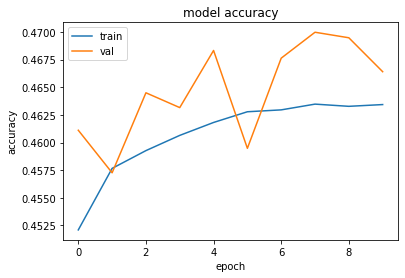

In [35]:
# Plot training curves
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
#Preparing targets in the test data for performance comparison + Predicting ratings for test data

y_test_encoded = encoder.transform(y_test)
y_test_ohe = np_utils.to_categorical(y_test_encoded)


y_pred = model.predict_classes(x_test)
y_pred += 1 #to match the labels as model outputs values 0-4 instead of 1-5 which label encoder uses

y_pred_encoded = encoder.transform(y_pred)
y_pred_ohe = np_utils.to_categorical(y_pred_encoded)

In [37]:
#To print classification report with metrics such as accuracy, precision, recall and f1-score

target_names = ['1', '2', '3', '4', '5']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.50      0.56      0.53    208544
           2       0.18      0.31      0.23    155708
           3       0.26      0.31      0.28    214697
           4       0.40      0.35      0.37    419794
           5       0.71      0.59      0.64    715373

    accuracy                           0.47   1714116
   macro avg       0.41      0.42      0.41   1714116
weighted avg       0.50      0.47      0.48   1714116



In [38]:
#Print confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[117674  47287  15882  10800  16901]
 [ 37467  48563  30993  20047  18638]
 [ 22662  41863  65497  51877  32798]
 [ 22314  57367  89406 145798 104909]
 [ 35335  71199  46049 140240 422550]]


Confusion matrix, without normalization
[[117674  47287  15882  10800  16901]
 [ 37467  48563  30993  20047  18638]
 [ 22662  41863  65497  51877  32798]
 [ 22314  57367  89406 145798 104909]
 [ 35335  71199  46049 140240 422550]]


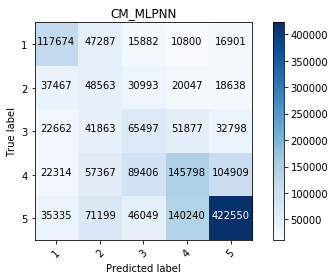

In [39]:
plot_confusion_matrix(cm, target_names, normalize = False, title = 'CM_MLPNN')

Normalized confusion matrix
[[0.56426462 0.22674831 0.07615659 0.05178763 0.08104285]
 [0.24062347 0.31188507 0.19904565 0.1287474  0.11969841]
 [0.10555341 0.19498642 0.30506714 0.2416289  0.15276413]
 [0.05315464 0.13665512 0.21297589 0.34730844 0.24990591]
 [0.04939381 0.0995271  0.06437062 0.19603759 0.59067088]]


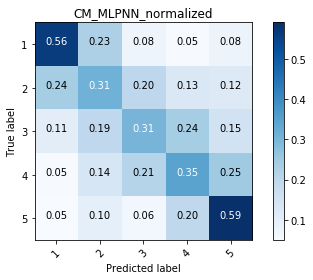

In [40]:
plot_confusion_matrix(cm, target_names, normalize = True, title = 'CM_MLPNN_normalized')

### <center> END <center>